In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
df = pd.read_csv("../data/auto-mpg.csv")
df = df.dropna()
df.drop(columns=["Unnamed: 0"], inplace=True)
df.reset_index(drop=True, inplace=True)


Q1 = df['displacement'].quantile(0.25)
Q3 = df['displacement'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df = df[(df['displacement'] >= lower_bound) & (df['displacement'] <= upper_bound)]

y = df['displacement'].values
X = df.values[:, 1:]

Text(0.5, 1.0, 'Correlation Matrix of Auto MPG Features')

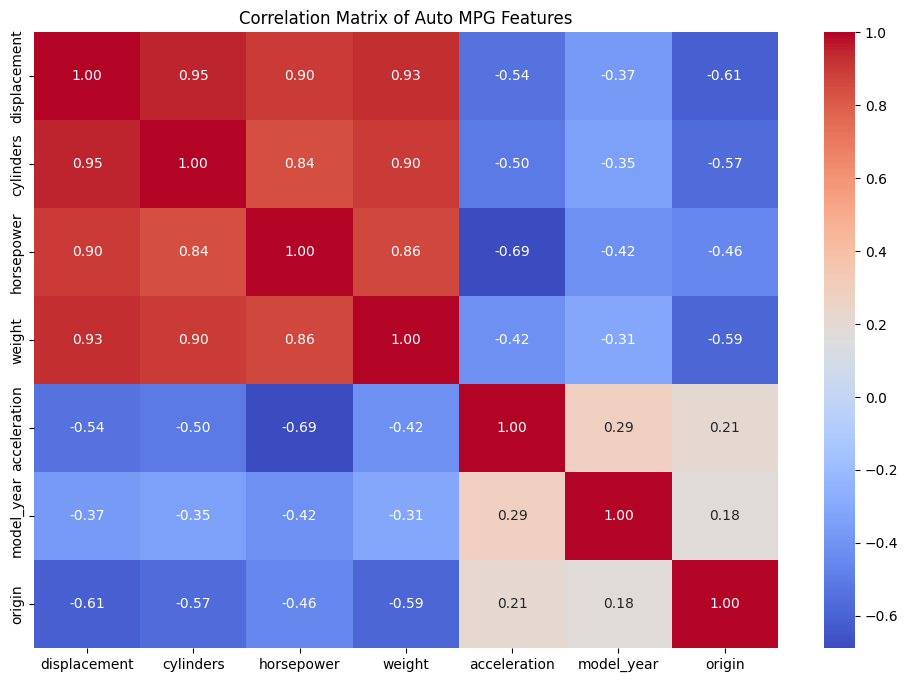

In [3]:
plt.figure(figsize=(12, 8))
numerical_cols = df.columns
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Auto MPG Features')

In [4]:
# Histogram Visualizations
# TODO

# Simple Regression

## In Sample

In [5]:
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              6170.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):                        0.00
Time:                        01:05:40   Log-Likelihood:                         -1775.4
No. Observations:                 392   AIC:                                      3563.
Df Residuals:                     386   BIC:                                      3587.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Train test split

In [6]:

test_split = 0.33
X_train = X[0:int(len(X)*(1-test_split)), :]
y_train = y[0:int(len(y)*(1-test_split))]
X_test = X[int(len(X)*(1-test_split)):, :]
y_test = y[int(len(y)*(1-test_split)):]


model_train = sm.OLS(y_train, X_train)
results_train = model_train.fit()

# Predict on test data
y_pred = results_train.predict(X_test)

print(results_train.summary())

# Test R^2 statistics
from statsmodels.tools.eval_measures import mse, rmse, meanabs
print(f"Test MSE: {mse(y_test, y_pred):.3f}")
print(f"Test RMSE: {rmse(y_test, y_pred):.3f}")
print(f"Test MAE: {meanabs(y_test, y_pred):.3f}")


# R^2 for test set
ss_err = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_test = 1 - ss_err / ss_tot
print(f"Test R^2 (manual): {r2_test:.3f}")


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              4709.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):                   8.61e-259
Time:                        01:05:40   Log-Likelihood:                         -1194.9
No. Observations:                 262   AIC:                                      2402.
Df Residuals:                     256   BIC:                                      2423.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## 5x Cross Validation


In [7]:
n_splits = 5
fold_size = len(y) // n_splits

r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []

for i in range(n_splits):
    start = i * fold_size
    end = (i + 1) * fold_size if i < n_splits - 1 else len(y)
    X_test = X[start:end, :]
    y_test = y[start:end]
    X_train = np.concatenate((X[:start, :], X[end:, :]), axis=0)
    y_train = np.concatenate((y[:start], y[end:]), axis=0)

    model = sm.OLS(y_train, X_train)
    results = model.fit()
    y_pred = results.predict(X_test)

    # Calculate statistics
    ss_err = np.sum((y_test - y_pred) ** 2)
    ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
    r2 = 1 - ss_err / ss_tot
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - y_pred))

    r2_scores.append(r2)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"5x CV Mean R^2: {np.mean(r2_scores):.3f}")
print(f"5x CV Mean MSE: {np.mean(mse_scores):.3f}")
print(f"5x CV Mean RMSE: {np.mean(rmse_scores):.3f}")
print(f"5x CV Mean MAE: {np.mean(mae_scores):.3f}")

5x CV Mean R^2: 0.915
5x CV Mean MSE: 572.401
5x CV Mean RMSE: 23.540
5x CV Mean MAE: 17.990


In [11]:
# --- AI generated ---

# Define features (X) and target (y)
features = numerical_cols[1:]
X = df[features]
y = df['displacement']

# Add a constant (intercept) to our model
X_with_const = sm.add_constant(X)

def forward_selection(X, y):
    """
    Performs forward selection using adjusted R-squared.
    """
    initial_features = X.columns.tolist()
    best_features = []
    # This loop logic has a small flaw where it will always select all features.
    # A better stopping criterion would be to monitor the change in adj. R-squared.
    # For this implementation, we will keep it as is to demonstrate the process.
    while (len(best_features) < len(initial_features)):
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype='float64')
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.rsquared_adj
        best_feature = new_pval.idxmax()
        best_features.append(best_feature)
    # Final model with selected features
    final_model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
    return best_features, final_model.rsquared_adj

def backward_elimination(X, y, significance_level=0.05):
    """
    Performs backward elimination using p-values.
    """
    features = X.columns.tolist()
    while(len(features) > 0):
        features_with_const = sm.add_constant(X[features])
        p_values = sm.OLS(y, features_with_const).fit().pvalues[1:] # Exclude intercept
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    # Final model with selected features
    final_model = sm.OLS(y, sm.add_constant(X[features])).fit()
    return features, final_model.rsquared_adj

def stepwise_selection(X, y, significance_level_in=0.05, significance_level_out=0.05):
    """
    Performs stepwise selection using p-values.
    """
    initial_features = X.columns.tolist()
    best_features = []
    while (True):
        changed = False
        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype='float64')
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value < significance_level_in):
            best_features.append(new_pval.idxmin())
            changed = True
        
        # Backward step
        if len(best_features) > 0:
            best_features_with_const = sm.add_constant(X[best_features])
            p_values = sm.OLS(y, best_features_with_const).fit().pvalues[1:]
            max_p_value = p_values.max()
            if(max_p_value >= significance_level_out):
                best_features.remove(p_values.idxmax())
                changed = True

        if not changed:
            break
            
    # Final model with selected features
    final_model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
    return best_features, final_model.rsquared_adj



# --- Run Selection Methods ---
print("\nPerforming Forward Selection...")
forward_features, forward_r2 = forward_selection(X, y)
print(f"Selected features (Forward Selection): {forward_features}")
print(f"Adjusted R-squared with selected features: {forward_r2:.4f}")

print("\nPerforming Backward Elimination...")
backward_features, backward_r2 = backward_elimination(X, y)
print(f"Selected features (Backward Elimination): {backward_features}")
print(f"Adjusted R-squared with selected features: {backward_r2:.4f}")

print("\nPerforming Stepwise Selection...")
stepwise_features, stepwise_r2 = stepwise_selection(X, y)
print(f"Selected features (Stepwise Selection): {stepwise_features}")
print(f"Adjusted R-squared with selected features: {stepwise_r2:.4f}")





Performing Forward Selection...
Selected features (Forward Selection): ['cylinders', 'weight', 'horsepower', 'origin', 'acceleration', 'model_year']
Adjusted R-squared with selected features: 0.9535

Performing Backward Elimination...
Selected features (Backward Elimination): ['cylinders', 'horsepower', 'weight', 'origin']
Adjusted R-squared with selected features: 0.9531

Performing Stepwise Selection...
Selected features (Stepwise Selection): ['cylinders', 'weight', 'horsepower', 'origin']
Adjusted R-squared with selected features: 0.9531


In [ ]:
import numpy as np